# DeepVCF: A Variant Caller using deep learning
#####  This tutorial on how to train and use DeepVCF to call variants and produce a Variant Call Format (VCF) file

In [1]:
from pprint import pprint

import pandas as pd
import seaborn as sns

from DeepVCF import pathing
from DeepVCF import biopandas as bpd
from DeepVCF import alignment
from DeepVCF.core import DeepVCF

deepvcf = DeepVCF()

=== No GPU Detected ===


# Pulling in Training & Testing Data
### We created these through the read simulator DWGSIM in the [tutorial](./creating-data-for-usage-demo.ipynb). The training and testing will be for both 2% platform base error (low) rate and 10% platform base error (high) rate with a .5% mutation rate for each. The goal is compare DeepVCF againset BCFtools regarding SNP variant calling when given low and high platform error rates. 

In [2]:
ref_train_be10percent = pathing('./example_files/staphylococcus/train/MRSA107.fasta')
bam_train_be10percent = pathing('./example_files/staphylococcus/train/train-base-error-10percent.mapped.bam')
vcf_train_be10percent = pathing('./example_files/staphylococcus/train/train-base-error-10percent.mutations.vcf')

ref_test_be10percent = pathing('./example_files/staphylococcus/test/GCF_000013425.1_ASM1342v1_genomic_reference.fasta')
bam_test_be10percent = pathing('./example_files/staphylococcus/test/test-base-error-10percent.mapped.bam')
vcf_test_be10percent = pathing('./example_files/staphylococcus/test/test-base-error-10percent.mutations.vcf')

ref_train_be2percent = pathing('./example_files/staphylococcus/train/MRSA107.fasta')
bam_train_be2percent = pathing('./example_files/staphylococcus/train/train-base-error-2percent.mapped.bam')
vcf_train_be2percent = pathing('./example_files/staphylococcus/train/train-base-error-2percent.mutations.vcf')

ref_test_be2percent = pathing('./example_files/staphylococcus/test/GCF_000013425.1_ASM1342v1_genomic_reference.fasta')
bam_test_be2percent = pathing('./example_files/staphylococcus/test/test-base-error-2percent.mapped.bam')
vcf_test_be2percent = pathing('./example_files/staphylococcus/test/test-base-error-2percent.mutations.vcf')

samtools_variant_calls_be2percent = pathing('./example_files/staphylococcus/test-base-error-2percent.bcftools.vcf')
samtools_variant_calls_be10percent = pathing('./example_files/staphylococcus/test-base-error-10percent.bcftools.vcf')

# Train Model
### VCF file needed to train and assumed to be high-confidence or "truth"

In [43]:
%%time
deepvcf.train(
    reference_file=ref_train_be2percent,
    alignment_file=bam_train_be2percent,
    vcf_file=vcf_train_be2percent,
    mimimum_alignment_coverage=.75,
    minimum_coverage=30,
    heterozygous_threshold=.25,
    minimum_variant_radius=15,
    # save_pileup_to_destination='./example_files/staphylococcus/train/train.pileup.npy',
    # use_saved_pileup='./example_files/staphylococcus/train/train.pileup.npy',  # Ignore the error, this will fail the first time if it doesn't exist
)

=== Building Pileup From Scratch ===
=== Pilup Complete ===
=== Tensors Complete ===
Epoch 1/30
360/360 [==============================] - 3s 8ms/step - loss: 0.6732 - base_loss: 0.4467 - genotype_loss: 0.4529 - base_accuracy: 0.5299 - genotype_accuracy: 0.8521 - val_loss: 0.3158 - val_base_loss: 0.2760 - val_genotype_loss: 0.0796 - val_base_accuracy: 0.7369 - val_genotype_accuracy: 0.9817
Epoch 2/30
360/360 [==============================] - 3s 8ms/step - loss: 0.3369 - base_loss: 0.2880 - genotype_loss: 0.0978 - base_accuracy: 0.6474 - genotype_accuracy: 0.9752 - val_loss: 0.2960 - val_base_loss: 0.2638 - val_genotype_loss: 0.0644 - val_base_accuracy: 0.6795 - val_genotype_accuracy: 0.9867
Epoch 3/30
360/360 [==============================] - 3s 7ms/step - loss: 0.3143 - base_loss: 0.2724 - genotype_loss: 0.0837 - base_accuracy: 0.6479 - genotype_accuracy: 0.9805 - val_loss: 0.2955 - val_base_loss: 0.2658 - val_genotype_loss: 0.0593 - val_base_accuracy: 0.6889 - val_genotype_accuracy

# Model Structure

In [4]:
deepvcf.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 4, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 4, 16)    208         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 11, 4, 16)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 4, 32)    4128        max_pooling2d[0][0]              
______________________________________________________________________________________________

# Example Pileup & Tensor

In [123]:
position = 9
print(deepvcf.preprocess.ref_seq[position:position+15])
print('=== Tensor ===')
deepvcf.preprocess.pileup[4:19, :]

CATCTTTCTTAAATT
=== Tensor ===


array([[0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0]])

In [124]:
position = 9
print(deepvcf.preprocess.ref_seq[position:position+15])
print('=== Tensor ===')
deepvcf.preprocess.get_window(position+8).transpose()

CATCTTTCTTAAATT
=== Tensor ===


array([[[ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4,  4,  0,  0],
        [ 2,  0,  0,  2,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  2,  0,  2,  2,  4,  0,  4,  4,  0,  0,  0,  4,  4]],

       [[ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]])

# Model Internal Loss/Validation

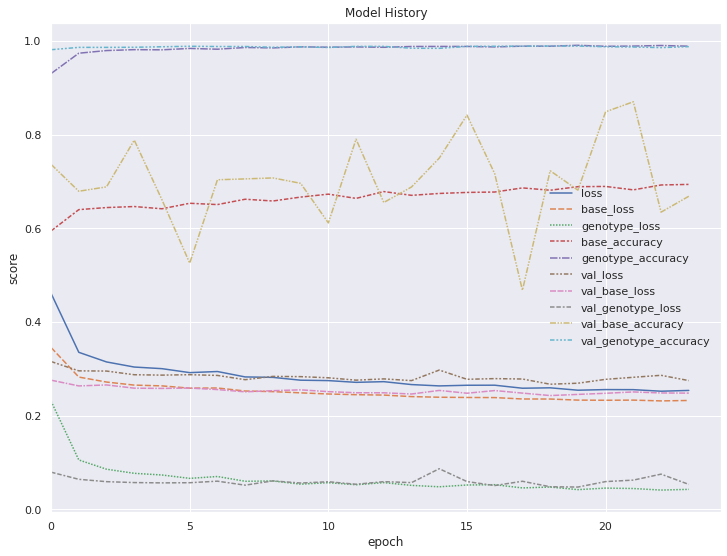

In [126]:
from matplotlib import rcParams, pyplot as plt
import dataframe_image as dfi
import seaborn as sns
# figure size in inches
rcParams['figure.figsize'] = 12,9
rcParams["legend.framealpha"] = 0.0
sns.set_theme()
sns.set(font_scale=1.0) 
snsplot = sns.lineplot(data=pd.DataFrame(deepvcf.model.history.history))
snsplot.set(xlabel='epoch', ylabel='score', title='Model History', xlim=0)
snsplot.figure.savefig('example_files/images/bacterial-model-history.png')

# Use Model to generate a Variant Format File (VCF)

In [6]:
%%time
predicted_vcf_test = deepvcf.create_vcf(
    reference_file=ref_test_be2percent,
    alignment_file=bam_test_be2percent,
    # save_pileup_to_destination='./example_files/staphylococcus/test/test.pileup.npy',
    # use_saved_pileup='./example_files/staphylococcus/test/test.pileup.npy',  # Ignore the error, this will fail the first time if it doesn't exist
    mimimum_alignment_coverage=.75,
    minimum_coverage=30,
    heterozygous_threshold=.25,
    minimum_variant_radius=15,
    output_folder='./example_files/staphylococcus/test/',  # save as an actual .vcf file
    output_prefix='test' 
)

=== Building Pileup From Scratch ===
=== Pilup Complete ===
=== Tensors Complete ===
CPU times: user 1min 43s, sys: 698 ms, total: 1min 43s
Wall time: 1min 41s


# Your predicted Variant Calls from the return

In [7]:
predicted_vcf_test.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,Sample1
0,NC_007795.1,656,.,C,A,.,PASS,"DLGA=0.0,1.0,0.0,0.0;DLAA=1.0,0.0,0.0,0.0",GT,{'GT': '1/1'}
1,NC_007795.1,1005,.,C,T,.,PASS,"DLGA=0.0,1.0,0.0,0.0;DLAA=0.0,0.0,0.0,1.0",GT,{'GT': '1/1'}
2,NC_007795.1,1501,.,G,T,.,PASS,"DLGA=0.999,0.001,0.0,0.0;DLAA=0.001,0.0,0.468,...",GT,{'GT': '0/1'}
3,NC_007795.1,1520,.,G,T,.,PASS,"DLGA=0.0,1.0,0.0,0.0;DLAA=0.0,0.0,0.0,1.0",GT,{'GT': '1/1'}
4,NC_007795.1,1533,.,A,C,.,PASS,"DLGA=0.991,0.009,0.0,0.0;DLAA=0.514,0.559,0.00...",GT,{'GT': '0/1'}


# Your predicted Variant Calls from the file saved

In [8]:
predicted_vcf_test = bpd.read_vcf('./example_files/staphylococcus/test/test.deepvcf.vcf')
predicted_vcf_test

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,Sample1
0,NC_007795.1,656,.,C,A,.,PASS,"DLGA=0.0,1.0,0.0,0.0;DLAA=1.0,0.0,0.0,0.0",GT,{'GT': '1/1'}
1,NC_007795.1,1005,.,C,T,.,PASS,"DLGA=0.0,1.0,0.0,0.0;DLAA=0.0,0.0,0.0,1.0",GT,{'GT': '1/1'}
2,NC_007795.1,1501,.,G,T,.,PASS,"DLGA=0.999,0.001,0.0,0.0;DLAA=0.001,0.0,0.468,...",GT,{'GT': '0/1'}
3,NC_007795.1,1520,.,G,T,.,PASS,"DLGA=0.0,1.0,0.0,0.0;DLAA=0.0,0.0,0.0,1.0",GT,{'GT': '1/1'}
4,NC_007795.1,1533,.,A,C,.,PASS,"DLGA=0.991,0.009,0.0,0.0;DLAA=0.514,0.559,0.00...",GT,{'GT': '0/1'}
...,...,...,...,...,...,...,...,...,...,...
12573,NC_007795.1,2819650,.,T,G,.,PASS,"DLGA=0.0,1.0,0.0,0.0;DLAA=0.0,0.0,1.0,0.0",GT,{'GT': '1/1'}
12574,NC_007795.1,2820369,.,G,C,.,PASS,"DLGA=0.99,0.01,0.0,0.0;DLAA=0.009,0.477,0.533,...",GT,{'GT': '0/1'}
12575,NC_007795.1,2820389,.,T,A,.,PASS,"DLGA=0.998,0.002,0.0,0.0;DLAA=0.508,0.0,0.0,0.531",GT,{'GT': '0/1'}
12576,NC_007795.1,2820492,.,G,C,.,PASS,"DLGA=0.983,0.016,0.001,0.001;DLAA=0.006,0.5,0....",GT,{'GT': '0/1'}


# Valitdation Metrics

In [9]:
bpd.read_vcf(vcf_test_be2percent)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,Sample1
0,NC_007795.1,42,.,A,T,100,PASS,AF=1.0;pl=3;mt=SUBSTITUTE,GT,{'GT': '1/1'}
1,NC_007795.1,159,.,CAG,C,100,PASS,AF=1.0;pl=3;mt=DELETE,GT,{'GT': '1/1'}
2,NC_007795.1,656,.,C,A,100,PASS,AF=1.0;pl=3;mt=SUBSTITUTE,GT,{'GT': '1/1'}
3,NC_007795.1,1005,.,C,T,100,PASS,AF=1.0;pl=3;mt=SUBSTITUTE,GT,{'GT': '1/1'}
4,NC_007795.1,1501,.,G,T,100,PASS,AF=0.5;pl=1;mt=SUBSTITUTE,GT,{'GT': '0/1'}
...,...,...,...,...,...,...,...,...,...,...
14062,NC_007795.1,2820389,.,T,A,100,PASS,AF=0.5;pl=2;mt=SUBSTITUTE,GT,{'GT': '0/1'}
14063,NC_007795.1,2820492,.,G,C,100,PASS,AF=0.5;pl=2;mt=SUBSTITUTE,GT,{'GT': '0/1'}
14064,NC_007795.1,2820653,.,G,C,100,PASS,AF=1.0;pl=3;mt=SUBSTITUTE,GT,{'GT': '1/1'}
14065,NC_007795.1,2820660,.,A,AC,100,PASS,AF=1.0;pl=3;mt=INSERT,GT,{'GT': '1/1'}


In [10]:
# compare test to predicted
metrics = deepvcf.validation(
    predicted_vcf=predicted_vcf_test,
    real_vcf=vcf_test_be2percent,
)
metrics

{'hom_alt': {'Sensitivity': 0.9872701555869873,
  'PPV': 0.9964311206281228,
  'Accuracy': 0.9945028680688337,
  'F1': 0.991829484902309},
 'het': {'Sensitivity': 0.9890293346052945,
  'PPV': 0.990446620491999,
  'Accuracy': 0.9864074600916706,
  'F1': 0.9897374701670645}}

# Now we know the complete pipeline lets compare metrics for DeepVCF VS. BCFtools when base errors are 2% and 10%

# 2% trained - 2% tested

In [11]:
deepvcf = DeepVCF()
pileup = './example_files/staphylococcus/train/train-base-error-2percent.pileup.npy'
deepvcf.train(
    reference_file=ref_train_be2percent,
    alignment_file=bam_train_be2percent,
    vcf_file=vcf_train_be2percent,
    mimimum_alignment_coverage=.75,
    minimum_coverage=30,
    heterozygous_threshold=.25,
    minimum_variant_radius=15,
    # save_pileup_to_destination=pileup,
    # use_saved_pileup=pileup,  # Ignore the error, this will fail the first time if it doesn't exist
    verbose=0,
)
dvf_be2 = deepvcf.create_vcf(
    reference_file=ref_test_be2percent,
    alignment_file=bam_test_be2percent,
    # save_pileup_to_destination='./example_files/staphylococcus/test/test-base-error-2percent.pileup.npy',
    # use_saved_pileup='./example_files/staphylococcus/test/test-base-error-2percent.pileup.npy',    
    mimimum_alignment_coverage=.75,
    minimum_coverage=30,
    heterozygous_threshold=.25,
    minimum_variant_radius=15,
    output_folder='./example_files',  # save as an actual .vcf file
    output_prefix='demo-be-2-2' 
)

=== Building Pileup From Scratch ===
=== Pilup Complete ===
=== Tensors Complete ===
=== Building Pileup From Scratch ===
=== Pilup Complete ===
=== Tensors Complete ===


In [12]:
dvf_be2_metrics = deepvcf.validation(real_vcf=vcf_test_be2percent, predicted_vcf=dvf_be2)
dvf_be2_metrics

{'hom_alt': {'Sensitivity': 0.9839698255539839,
  'PPV': 0.995706106870229,
  'Accuracy': 0.9931485022307202,
  'F1': 0.9898031776144178},
 'het': {'Sensitivity': 0.9887908418793226,
  'PPV': 0.9887908418793226,
  'Accuracy': 0.9851430377746168,
  'F1': 0.9887908418793226}}

# 2% trained - 10% tested

In [13]:
deepvcf = DeepVCF()
deepvcf.train(
    reference_file=ref_train_be2percent,
    alignment_file=bam_train_be2percent,
    vcf_file=vcf_train_be2percent,
    mimimum_alignment_coverage=.75,
    minimum_coverage=30,
    heterozygous_threshold=.25,
    minimum_variant_radius=15,
    # save_pileup_to_destination='./example_files/staphylococcus/train/train-base-error-2percent.pileup.npy',
    # use_saved_pileup='./example_files/staphylococcus/train/train-base-error-2percent.pileup.npy',  # Ignore the error, this will fail the first time if it doesn't exist
    verbose=0,
)
dvf_be_2_10 = deepvcf.create_vcf(
    reference_file=ref_test_be10percent,
    alignment_file=bam_test_be10percent,
    # save_pileup_to_destination='./example_files/staphylococcus/test/test-base-error-10percent.pileup.npy',
    # use_saved_pileup='./example_files/staphylococcus/test/test-base-error-10percent.pileup.npy',  # Ignore the error, this will fail the first time if it doesn't exist
    mimimum_alignment_coverage=.75,
    minimum_coverage=30,
    heterozygous_threshold=.25,
    minimum_variant_radius=15,
    output_folder='./example_files/',  # save as an actual .vcf file
    output_prefix='demo-be-2-10' 
)

=== Building Pileup From Scratch ===
=== Pilup Complete ===
=== Tensors Complete ===
=== Building Pileup From Scratch ===
=== Pilup Complete ===
=== Tensors Complete ===


In [14]:
dvf_be_2_10_metrics = deepvcf.validation(real_vcf=vcf_test_be10percent, predicted_vcf=dvf_be_2_10)
dvf_be_2_10_metrics

{'hom_alt': {'Sensitivity': 0.9294308190652476,
  'PPV': 0.9982604373757455,
  'Accuracy': 0.9752577319587629,
  'F1': 0.9626168224299065},
 'het': {'Sensitivity': 0.9805779251539555,
  'PPV': 0.9708054871614492,
  'Accuracy': 0.9675059008654603,
  'F1': 0.9756672361986685}}

# 10% trained - 10% tested 

In [15]:
deepvcf = DeepVCF()
deepvcf.train(
    reference_file=ref_train_be10percent,
    alignment_file=bam_train_be10percent,
    vcf_file=vcf_train_be10percent,
    mimimum_alignment_coverage=.75,
    minimum_coverage=30,
    heterozygous_threshold=.25,
    minimum_variant_radius=15,
    # save_pileup_to_destination='./example_files/staphylococcus/train/train-base-error-10percent.pileup.npy',
    # use_saved_pileup='./example_files/staphylococcus/train/train-base-error-10percent.pileup.npy',  # Ignore the error, this will fail the first time if it doesn't exist
    verbose=0,
)
dvf_be10 = deepvcf.create_vcf(
    reference_file=ref_test_be10percent,
    alignment_file=bam_test_be10percent,
    # save_pileup_to_destination='./example_files/staphylococcus/test/test-base-error-10percent.pileup.npy',
    # use_saved_pileup='./example_files/staphylococcus/test/test-base-error-10percent.pileup.npy',  # Ignore the error, this will fail the first time if it doesn't exist
    mimimum_alignment_coverage=.75,
    minimum_coverage=30,
    heterozygous_threshold=.25,
    minimum_variant_radius=15,
    output_folder='./example_files',  # save as an actual .vcf file
    output_prefix='demo-be-10-10' 
)

=== Building Pileup From Scratch ===
=== Pilup Complete ===
=== Tensors Complete ===
=== Building Pileup From Scratch ===
=== Pilup Complete ===
=== Tensors Complete ===


In [16]:
dvf_be10_metrics = deepvcf.validation(real_vcf=vcf_test_be10percent, predicted_vcf=dvf_be10)
dvf_be10_metrics

{'hom_alt': {'Sensitivity': 0.96760758907913,
  'PPV': 0.99476688867745,
  'Accuracy': 0.9871530531324346,
  'F1': 0.9809992962702322},
 'het': {'Sensitivity': 0.9783278067266699,
  'PPV': 0.9904088238820286,
  'Accuracy': 0.9793011175822446,
  'F1': 0.9843312481382186}}

In [17]:
deepvcf = DeepVCF()
deepvcf.train(
    reference_file=ref_train_be10percent,
    alignment_file=bam_train_be10percent,
    vcf_file=vcf_train_be10percent,
    mimimum_alignment_coverage=.75,
    minimum_coverage=30,
    heterozygous_threshold=.25,
    minimum_variant_radius=15,
    # save_pileup_to_destination='./example_files/staphylococcus/train/train-base-error-10percent.pileup.npy',
    # use_saved_pileup='./example_files/staphylococcus/train/train-base-error-10percent.pileup.npy',  # Ignore the error, this will fail the first time if it doesn't exist
    verbose=0,
)
dvf_be_10_2 = deepvcf.create_vcf(
    reference_file=ref_test_be2percent,
    alignment_file=bam_test_be2percent,
    # save_pileup_to_destination='./example_files/staphylococcus/test/test-base-error-10percent.pileup.npy',
    # use_saved_pileup='./example_files/staphylococcus/test/test-base-error-2percent.pileup.npy',  # Ignore the error, this will fail the first time if it doesn't exist
    mimimum_alignment_coverage=.75,
    minimum_coverage=30,
    heterozygous_threshold=.25,
    minimum_variant_radius=15,
    output_folder='./example_files',  # save as an actual .vcf file
    output_prefix='demo-be-10-2' 
)

=== Building Pileup From Scratch ===
=== Pilup Complete ===
=== Tensors Complete ===
=== Building Pileup From Scratch ===
=== Pilup Complete ===
=== Tensors Complete ===


In [18]:
dvf_be_10_2_metrics = deepvcf.validation(real_vcf=vcf_test_be2percent, predicted_vcf=dvf_be_10_2)
dvf_be_10_2_metrics

{'hom_alt': {'Sensitivity': 0.9891560584629892,
  'PPV': 0.9783166239216601,
  'Accuracy': 0.9889260675589547,
  'F1': 0.9837064822412378},
 'het': {'Sensitivity': 0.9796088719294062,
  'PPV': 0.9914313299541395,
  'Accuracy': 0.9808756124545598,
  'F1': 0.9854846449136276}}

# BCFtools Variant calling 

## 2% base error

In [26]:
bcf_be2_metrics = deepvcf.validation(
    predicted_vcf=samtools_variant_calls_be2percent,
    real_vcf=vcf_test_be2percent,
)
pprint(bcf_be2_metrics)

{'het': {'Accuracy': 0.9932351172579675,
         'F1': 0.9946056101654279,
         'PPV': 0.9998794890335021,
         'Sensitivity': 0.9893870736942523},
 'hom_alt': {'Accuracy': 0.9977351653329307,
             'F1': 0.9964522232734153,
             'PPV': 0.9997626957759849,
             'Sensitivity': 0.9931636020744932}}


##  10% base error 

In [27]:
bcf_be10_metrics = deepvcf.validation(
    predicted_vcf=samtools_variant_calls_be10percent,
    real_vcf=vcf_test_be10percent,
)
pprint(bcf_be10_metrics)

{'het': {'Accuracy': 0.29926002409223884,
         'F1': 0.07222601959444065,
         'PPV': 0.9491017964071856,
         'Sensitivity': 0.03754144954997631},
 'hom_alt': {'Accuracy': 0.6540052651372696,
             'F1': 0.7745650575839255,
             'PPV': 0.8231770833333333,
             'Sensitivity': 0.7313743637204998}}


# Comparting DeepVCF with BCFtools when using noisy data

In [56]:
metrics = [
    dvf_be2_metrics,
    dvf_be10_metrics,
    dvf_be_2_10_metrics,
    dvf_be_10_2_metrics,
    bcf_be2_metrics,
    bcf_be10_metrics,
]
names = [
    'DVCF-2',
    'DVCF-10',
    'DVCF-2-10',
    'DVCF-10-2',
    'BCF-2',
    'BCF-10'
]
hom_alts = [{**{'tool':name}, **m['hom_alt']} for name, m in zip(names, metrics)]
hets = [{**{'tool': name}, **m['het']} for name, m in zip(names, metrics)]
hom_alt = pd.DataFrame(hom_alts)
het = pd.DataFrame(hets)

In [63]:
hom_alt.style.background_gradient()

,tool,Sensitivity,PPV,Accuracy,F1
0,DVCF-2,0.983970,0.995706,0.993149,0.989803
1,DVCF-10,0.967608,0.994767,0.987153,0.980999
2,DVCF-2-10,0.929431,0.998260,0.975258,0.962617
3,DVCF-10-2,0.989156,0.978317,0.988926,0.983706
4,BCF-2,0.993164,0.999763,0.997735,0.996452
5,BCF-10,0.731374,0.823177,0.654005,0.774565


In [64]:
het.style.background_gradient()

,tool,Sensitivity,PPV,Accuracy,F1
0,DVCF-2,0.988791,0.988791,0.985143,0.988791
1,DVCF-10,0.978328,0.990409,0.979301,0.984331
2,DVCF-2-10,0.980578,0.970805,0.967506,0.975667
3,DVCF-10-2,0.979609,0.991431,0.980876,0.985485
4,BCF-2,0.989387,0.999879,0.993235,0.994606
5,BCF-10,0.037541,0.949102,0.299260,0.072226


Here we can see BCFtools has a higher percision when the data is normal, but when the data has a high 10% base error rate it becomes unusable with heterozygous cals on the default settings and okay at homzygous alternatives.